The molecular kinetics community often builds discrete-state models of continuous-state time-series, called Markov State Models (MSMs).

**How do we compute the likelihood of a time-series given an MSM?**

Let's say we want to compute the likelihood of a vector-valued sequence given an MSM. The MSM is defined by (1) a partitioning of the entire continuous space into $n$ non-overlapping chunks, and (2) an $n \times n$ transition matrix $T$, where each entry $T_{ij}$ is the probability that you'll be anywhere in chunk $j$ if you start anywhere in chunk $i$ and wait a while.

The likelihood of a discrete sequence, $S = (s_1,s_2,\dots,s_N)$ is easy, it's just:

$$p(S) = p(s_1) \prod_{t=2}^N p(s_t | s_{t-1}) = p(s_1) \prod_{t=2}^N T_{s_{t-1} s_t}$$

This is what's currently done in MSMBuilder when you ask for a likelihood, for example: https://github.com/msmbuilder/msmbuilder/blob/master/msmbuilder/msm/msm.py#L318

But in the case of MSMs, this obviously doesn't tell the whole story. You could, for instance, choose a totally useless state-space partitioning that maps any possible vector to the same discrete state $(n=1, T = T_{11}=1.0)$, but evaluating this likelihood function would tell you that the probability of the sequence is $1.0$.

What we really want is the likelihood of a vector-valued sequence, $X = ( \vec{x}_1, \vec{x}_2, \dots, \vec{x}_N)$:

$$p(X) = p(\vec{x}_1) \prod_{t = 2}^N p(\vec{x}_t | \vec{x}_{t-1})$$

Evaluating this from an MSM requires one more step. This is because the probability density at any individual point in a partition is not equal to the probability of the whole partition-- instead the probability density has to *integrate* to that value. Consequently, the transition probability $p(\vec{x}_t | \vec{x}_{t-1})$ isn't simply equal the corresponding element of $T$. $T_{ij}$ is actually an integral:

$$T_{ij} = \int_{s_j} p(\vec{y} | \vec{x})d\vec{y}$$

where the "origin point" is anywhere in the partition $i$, $\vec{x} \in s_i$, and we integrate over all "destination points" in the partition $j$, $\vec{y} \in s_j$.

Since the transition density in an MSM is uniform within each partition, this integral should be easy. All we need is the volume $V_j$ of each partition:

$$\begin{aligned}T_{ij} & = V_j p(\vec{y} | \vec{x})\\
p(\vec{y} | \vec{x}) & = T_{ij}/{V_j}\end{aligned}$$

for any $\vec{x} \in s_i$, $\vec{y} \in s_j$.

So now we can compute the vector-to-vector transition probability from quantities that the MSM defines: the volume of each partition, and the transition matrix.

In [1]:
# basic imports
import numpy as np
import numpy.random as npr
npr.seed(0)
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# construct a 2-state Markov model, and sample a long trajectory

# the 2 states A and B are Gaussian blobs in 2D
A = (0,0)
B = (5,5)
centers = dict()
centers[0] = A
centers[1] = B

# the transition matrix is symmetric and metastable
trans_mat = np.array([[0.7,0.3],
                      [0.3,0.7]])

# sample a trajectory
traj_len=100000
traj=npr.randn(traj_len,2)
state = 0
for i in range(1,traj_len):
    state = int(npr.rand() > trans_mat[state][0]) # only works for 2-state MSM
    traj[i] += centers[state]

X = traj[:int(traj_len*0.9)]
X_test = traj[int(traj_len*0.9):]

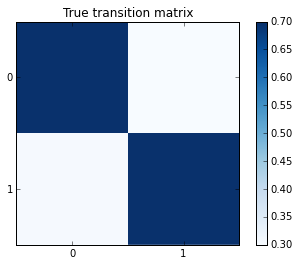

In [3]:
plt.imshow(trans_mat,interpolation='none',cmap='Blues');
plt.xticks([0,1])#,[r'$\mathcal{N}((0,0),1)$',r'$\mathcal{N}((5,5),1)$'])
plt.yticks([0,1])#,[r'$\mathcal{N}((0,0),1)$',r'$\mathcal{N}((5,5),1)$'])
plt.colorbar()
plt.title('True transition matrix')

In [4]:
# Use a library function for computing a state decomposition.
# In general we don't know the correct number of states beforehand, so let's over-estimate here:
from msmbuilder.cluster import MiniBatchKMedoids
kmed = MiniBatchKMedoids(n_clusters=8)
kmed.fit([X])

MiniBatchKMedoids(batch_size=100, max_iter=5, max_no_improvement=10,
         metric='euclidean', n_clusters=8, random_state=None)

In [5]:
# assign each point in the trajectory to a partition
clusters = kmed.transform([X])[0]

In [6]:
clusters

array([7, 0, 0, ..., 4, 0, 5])

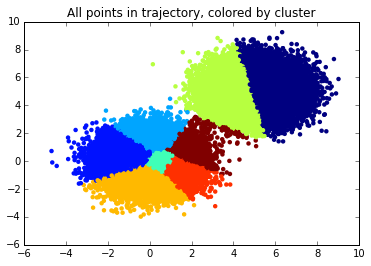

In [7]:
plt.scatter(X[:,0],X[:,1],c=clusters, linewidths=0)
plt.title('All points in trajectory, colored by cluster')

In [8]:
uniform = npr.rand(100000,2)*15-5
uniform_clusters = kmed.transform([uniform])[0]

<matplotlib.colorbar.Colorbar instance at 0x10d13cab8>

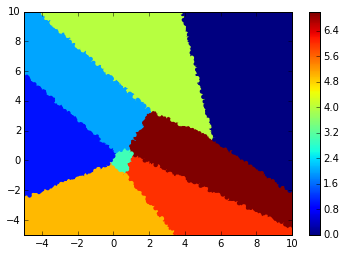

In [9]:
plt.scatter(uniform[:,0],uniform[:,1],c=uniform_clusters, linewidths=0)
plt.xlim(-5,10)
plt.ylim(-5,10)
plt.colorbar()

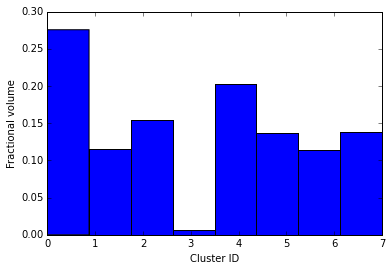

In [10]:
plt.hist(uniform_clusters,bins=len(set(uniform_clusters)),normed=True);
plt.xlabel('Cluster ID')
plt.ylabel('Fractional volume')

In [11]:
from msmbuilder.msm import MarkovStateModel

In [12]:
msm = MarkovStateModel()
msm.fit(clusters)

MSM contains 1 strongly connected component above weight=1.00. Component 0 selected, with population 100.000000%


MarkovStateModel(ergodic_cutoff=1.0, lag_time=1, n_timescales=10,
         prior_counts=0, reversible_type='mle', sliding_window=True,
         verbose=True)

In [13]:
clusters

array([7, 0, 0, ..., 4, 0, 5])

In [14]:
msm.score_ll([clusters])

-162738.90950436893

In [15]:
msm.score_ll(kmed.transform([X_test]))

-17961.369947497973

In [16]:
T = msm.transmat_

In [17]:
# T is row-normalized
T[0],np.sum(T[0])

(array([ 0.393207  ,  0.09053321,  0.04219531,  0.05193111,  0.30181058,
         0.06873631,  0.02912721,  0.02245926]), 1.0000000000000002)

In [18]:
# not column-normalized
np.sum(T[:,0])

1.7771448893957471

In [19]:
# let's compute the volume of each partition

def compute_cluster_volumes(total_volume,uniform_cluster_assignments):
    counts_per_cluster = np.zeros(uniform_cluster_assignments.max()+1)
    for x in uniform_cluster_assignments:
        counts_per_cluster[x] += 1.0
    fraction_in_cluster = counts_per_cluster / len(uniform_cluster_assignments)
    volumes = fraction_in_cluster * total_volume
    return volumes

total_volume = (uniform.max() - uniform.min())**(uniform.shape[1])
volumes = compute_cluster_volumes(total_volume,uniform_clusters)

In [20]:
T[0],volumes

(array([ 0.393207  ,  0.09053321,  0.04219531,  0.05193111,  0.30181058,
         0.06873631,  0.02912721,  0.02245926]),
 array([ 54.26056109,  22.65506675,  30.24650534,   1.28473961,
         39.95067684,  26.96153191,  22.33556933,  27.30352915]))

In [21]:
k = 1.0 / volumes
k*T[0]

array([ 0.00724664,  0.00399616,  0.00139505,  0.04042151,  0.00755458,
        0.00254942,  0.00130407,  0.00082258])

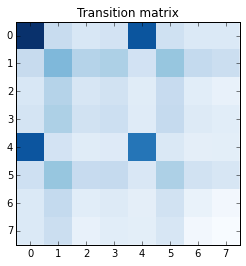

In [22]:
plt.imshow(T + T.T,interpolation='none',cmap='Blues');
plt.title("Transition matrix")

<Container object of 8 artists>

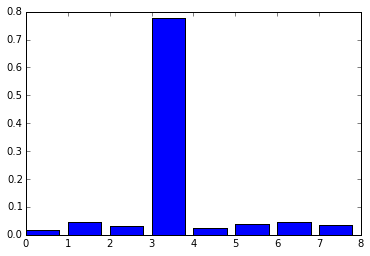

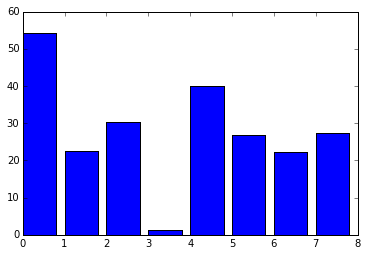

In [23]:
plt.bar(range(len(k)),k)
plt.figure()
plt.bar(range(len(k)),volumes)

In [24]:
# now let's score a trajectory

In [25]:
# prior probability *density* vector $\pi$
pi = msm.populations_*k
pi

array([ 0.00510055,  0.00657795,  0.00241941,  0.0667501 ,  0.00538753,
        0.00424396,  0.00219583,  0.00133969])

In [26]:
msm.populations_

array([ 0.27675852,  0.14902397,  0.07317867,  0.08575649,  0.21523553,
        0.11442358,  0.04904503,  0.03657821])

In [27]:
# log probabilities
log_pi = np.log(pi)
log_normalized_T = np.log(k*T)

In [28]:
def score_correctly_ll(sequence,log_pi,log_normalized_T):
    log_prob = log_pi[sequence[0]]
    for i in range(1,len(sequence)):
        log_prob += log_normalized_T[sequence[i-1],sequence[i]]
    return log_prob

In [29]:
score_correctly_ll(clusters,log_pi,log_normalized_T)

-458418.19890994485

In [30]:
score_correctly_ll(kmed.transform([X_test])[0],log_pi,log_normalized_T)

-50980.176168027727

In [31]:
# sanity check: what if we have a 1-state MSM?

# in MSMBuilder, we would first perform a clustering, then pass the sequence of cluster labels to be scored:
one_state_clusters = [np.zeros(len(clusters))]
msm = MarkovStateModel()
msm.fit(one_state_clusters)
print('MSMBuilder log likelihood: {0}'.format(msm.score_ll(one_state_clusters)))
# this leads to a probability of 1.0 for any observation sequence, even though the model contains no information

# for the corrected log_likelihood, we account for the volume of the cluster
log_pi = np.log(1.0/total_volume)
print('Corrected log likelihood: {0:.3f}'.format(log_pi*len(clusters)))
# that's thankfully a bit lower than the multi-state MSM log-likelihood-- sanity check passed!

MSM contains 1 strongly connected component above weight=1.00. Component 0 selected, with population 100.000000%
MSMBuilder log likelihood: 0.0
Corrected log likelihood: -487448.308


In [32]:
MarkovStateModel().fit([np.zeros(1000)]).score_ll([np.zeros(1000)])

MSM contains 1 strongly connected component above weight=1.00. Component 0 selected, with population 100.000000%


0.0

In [33]:
from msmbuilder.example_datasets import FsPeptide

In [34]:
fs = FsPeptide().get().trajectories

loading trajectory_1.xtc...
loading trajectory_10.xtc...
loading trajectory_11.xtc...
loading trajectory_12.xtc...
loading trajectory_13.xtc...
loading trajectory_14.xtc...
loading trajectory_15.xtc...
loading trajectory_16.xtc...
loading trajectory_17.xtc...
loading trajectory_18.xtc...
loading trajectory_19.xtc...
loading trajectory_2.xtc...
loading trajectory_20.xtc...
loading trajectory_21.xtc...
loading trajectory_22.xtc...
loading trajectory_23.xtc...
loading trajectory_24.xtc...
loading trajectory_25.xtc...
loading trajectory_26.xtc...
loading trajectory_27.xtc...
loading trajectory_28.xtc...
loading trajectory_3.xtc...
loading trajectory_4.xtc...
loading trajectory_5.xtc...
loading trajectory_6.xtc...
loading trajectory_7.xtc...
loading trajectory_8.xtc...
loading trajectory_9.xtc...


In [35]:
from msmbuilder.featurizer import DihedralFeaturizer

In [36]:
dih = DihedralFeaturizer(['phi', 'psi', 'omega', 'chi1', 'chi2', 'chi3', 'chi4']).fit_transform(fs)

In [37]:
dih[0].shape

(10000, 148)

In [38]:
np.vstack(dih).max(),np.vstack(dih).min()

(1.0, -1.0)

In [39]:
kmed_fs = MiniBatchKMedoids(n_clusters=10)
kmed_fs.fit(dih)

MiniBatchKMedoids(batch_size=100, max_iter=5, max_no_improvement=10,
         metric='euclidean', n_clusters=10, random_state=None)

In [40]:
clusters_fs = kmed_fs.transform(dih)

In [41]:
# simple monte carlo: uniformly throw darts in a 148-dimensional cube
uniform_fs = np.array(npr.rand(1000000,dih[0].shape[1]),dtype='float32')*2 - 1
uniform_clusters_fs = kmed_fs.transform([uniform_fs])[0]

In [42]:
frac_volume = np.array([np.sum(uniform_clusters_fs==i) for i in range(10)],dtype=float) / len(uniform_clusters_fs)

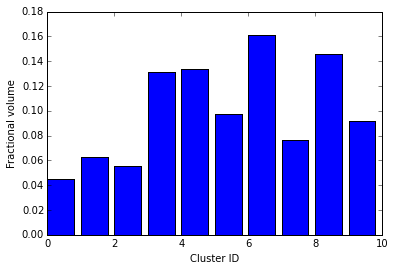

In [43]:
plt.bar(range(10),frac_volume);
plt.xlabel('Cluster ID')
plt.ylabel('Fractional volume')

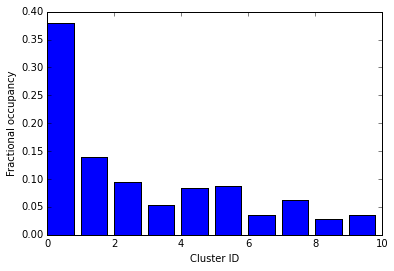

In [44]:
occupancy = np.array([np.sum(np.vstack(clusters_fs)==i) for i in range(10)],dtype=float)
frac_occupancy = occupancy / np.sum(occupancy)
plt.bar(range(10),frac_occupancy);
plt.xlabel('Cluster ID')
plt.ylabel('Fractional occupancy')

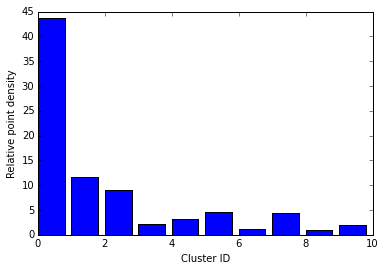

In [45]:
point_density = frac_occupancy / frac_volume
plt.bar(range(10),point_density / np.min(point_density));
plt.xlabel('Cluster ID')
plt.ylabel('Relative point density')

In [46]:
# in this case, bigger clusters are not necessarily more populous, with some clusters up to ~40x more dense with observed points
# than others

In [47]:
uniform_clusters_fs

array([4, 3, 4, ..., 4, 8, 3])

In [48]:
# total volume: yikes! that's large!
total_volume_fs = 2.0**148
total_volume_fs

3.5681192317649e+44

In [49]:
# Now we can score this MSM the same way as above...

volumes_fs = compute_cluster_volumes(total_volume_fs,uniform_clusters_fs)

In [50]:
volumes_fs

array([  1.61996181e+43,   2.22532892e+43,   1.97491831e+43,
         4.67616298e+43,   4.76258283e+43,   3.48787223e+43,
         5.74734805e+43,   2.71405421e+43,   5.20731321e+43,
         3.26564976e+43])

In [51]:
msm_fs = MarkovStateModel(prior_counts=1)
msm_fs.fit(clusters_fs)

MSM contains 1 strongly connected component above weight=1.00. Component 0 selected, with population 100.000000%


MarkovStateModel(ergodic_cutoff=1.0, lag_time=1, n_timescales=10,
         prior_counts=1, reversible_type='mle', sliding_window=True,
         verbose=True)

In [52]:
def compute_normalized_log_probs_from_msm(msm,volumes):
    k = 1.0/volumes
    pi = msm.populations_*k
    log_pi = np.log(pi)
    T = msm.transmat_
    log_normalized_T = np.log(k*T)
    return log_pi,log_normalized_T

In [53]:
log_pi_fs,log_normalized_T_fs = compute_normalized_log_probs_from_msm(msm_fs,volumes_fs)

In [54]:
lls = []
for traj in clusters_fs:
    lls.append(score_correctly_ll(traj,log_pi_fs,log_normalized_T_fs))

In [55]:
np.sum(lls)

-28286089.012853153

Another proposed likelihood function: write $$\mathcal{L}(D | T, S) = \left[\prod_{n=1}^{N}T_{s_{n-1}}{s_n}\right] \left[\prod_{n=1}^{N} \frac{e^{-U(x_n)}}{\pi_{s_n} \right] \left[\prod_{n=1}^{N} \pi_{s_i}\right]$$